In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.layers import Dense,Dropout
from keras.models import Sequential
import keras

In [0]:
# відкриваємо наші дані
df = pd.read_excel('Data/BreastTissue.xlsx', sheet_name = 'Data')

In [86]:
df.head(5) # Зображаємо нашу таблицю даних

,Case #,Class,I0,PA500,HFS,DA,Area,A/DA,Max IP,DR,P
0,1,car,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334
1,2,car,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776
2,3,car,551.879287,0.232478,0.063530,264.804935,11888.391827,44.894903,77.793297,253.785300,656.769449
3,4,car,380.000000,0.240855,0.286234,137.640111,5402.171180,39.248524,88.758446,105.198568,493.701814
4,5,car,362.831266,0.200713,0.244346,124.912559,3290.462446,26.342127,69.389389,103.866552,424.796503


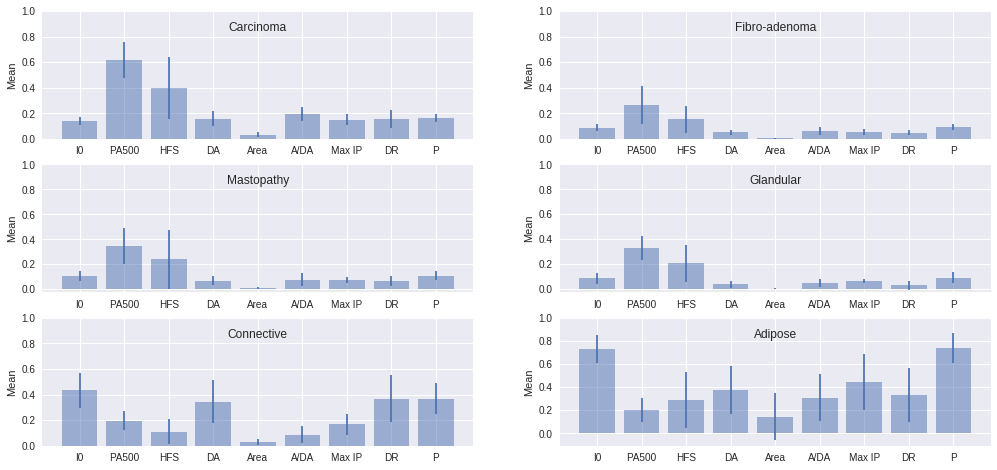

In [125]:
# Зобразимо розподіл параметрів для всіх класів хвороб

classes = df['Class'].unique()

cl=['Carcinoma',
'Fibro-adenoma',
'Mastopathy',
'Glandular',
'Connective',
'Adipose']

plt.figure(figsize=(17, 8))
for i in range(len(classes)):
    f = df['Class'] == classes[i]

    objects = df.columns[2:]
    y_pos = np.arange(len(objects))
    performance = df[f][df.columns[2:]].mean()/df[df.columns[2:]].max()
    e = df[f][df.columns[2:]].std()/df[df.columns[2:]].max()
    
    plt.subplot(3, 2, i+1)
    plt.errorbar(y_pos, performance, e, linestyle='None',)

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Mean')
    plt.title(cl[i],y=0.8)
    plt.ylim(top=1)

plt.show()

Зверніть увагу, що розподіли параметрів для Фіброаденоми, мастопатії та мононуклеозу (Fibro-adenoma, Mastopathy, Glandular) майже ідентичні. 

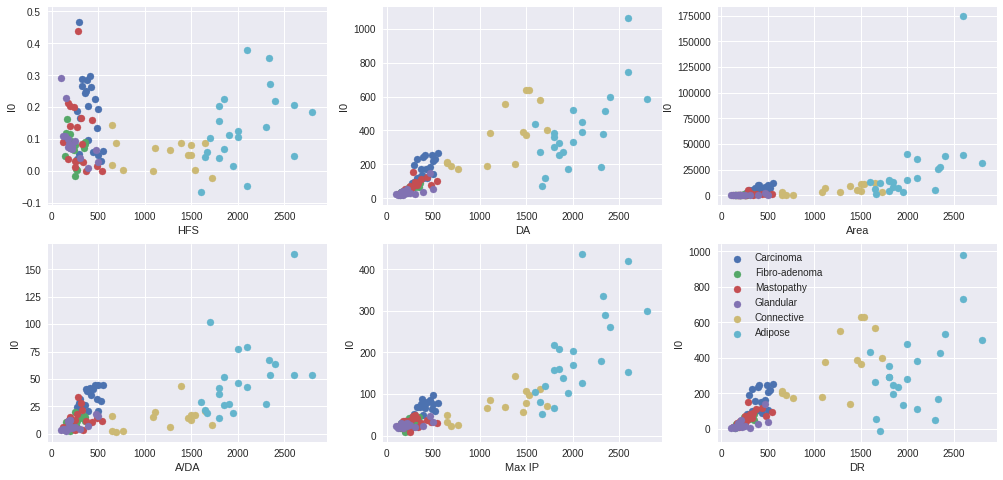

In [123]:
# Зобразимо на графіках залежність деяких параметрів для кожного класу хвороб

plt.figure(figsize=(17, 8))
for i in range(6):  
  plt.subplot(2, 3, i+1)
  for j in classes:
    plt.scatter(df[df['Class']==j]['I0'],df[df['Class']==j][df.columns[4+i]])
  plt.ylabel('I0')
  plt.xlabel(df.columns[4+i])
plt.legend(cl)
plt.show()

Як бачимо з графіків, параметри для фіброаденоми, мастопатії та мононуклеозу (Fibro-adenoma, Mastopathy, Glandular) майже нероздільні за цим методом, що може впливати на точність визначення хвороб. Доцільно звести ці три хвороби в один клас для точнішої класифікації. Для початку зробимо модель для визначення всіх хвороб і подивимся чи справді фіброаденома, мастопатія та мононуклеоз погано класифікуються. 

In [12]:
# переводимо абревіатури хвороб в цілі числа
classes = df['Class'].unique()

for i in range(len(classes)):
    df['Class'][df['Class']==classes[i]] = i
    
df.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Case #,Class,I0,PA500,HFS,DA,Area,A/DA,Max IP,DR,P
0,1,0,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334
1,2,0,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776
2,3,0,551.879287,0.232478,0.063530,264.804935,11888.391827,44.894903,77.793297,253.785300,656.769449
3,4,0,380.000000,0.240855,0.286234,137.640111,5402.171180,39.248524,88.758446,105.198568,493.701814
4,5,0,362.831266,0.200713,0.244346,124.912559,3290.462446,26.342127,69.389389,103.866552,424.796503


In [0]:
# Нормуємо дані

x = df.iloc[:,2:] # зберігаємо параметри (I0, PA500, HFS, DA, Area, A/DA, Max IP, DR, P) в змінній "x"
for i in range(9):
    x.iloc[:,i] = x.iloc[:,i]/x.iloc[:,i].max()

x = x.values
y = df.iloc[:,1].values # зберігаємо класи хвороб в змінній "y"
y = y.astype('int')

In [14]:
# Оскільки вибірка мала, проводимо "train test split" для кожного класу хвороб окремо

x_test = []
y_test = []
x_train = []
y_train = []

for i in np.unique(y):
  
  temp_x_train, temp_x_test, temp_y_train, temp_y_test = train_test_split(x[y==i], y[y==i], test_size=0.4, random_state = 3)
  
  x_test += temp_x_test.tolist()
  y_test += temp_y_test.tolist()
  x_train += temp_x_train.tolist()
  y_train += temp_y_train.tolist()

x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = np.array(x_train)
y_train = np.array(y_train)

# Перевіряємо, які класи хвороб потрапили у вибірку і яка їх кількість
print('test: ',np.unique(y_test, return_counts = True))
print('train: ',np.unique(y_train, return_counts = True))

test:  (array([0, 1, 2, 3, 4, 5]), array([9, 6, 8, 7, 6, 9]))
train:  (array([0, 1, 2, 3, 4, 5]), array([12,  9, 10,  9,  8, 13]))


In [0]:
# конвертуємо класи хвороб у векторну форму
num_category = 6

y_train = keras.utils.to_categorical(y_train, num_category)
y_test = keras.utils.to_categorical(y_test, num_category)

In [31]:
# будуємо модель

batch_size = y_train.shape[0] # оскільки вибірка мала "batch_size" 

model = Sequential()
model.add(Dense(170, activation='relu') )

model.add(Dense(num_category, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(lr=0.0025),
                metrics=['accuracy'])


num_epoch = 650


model_log = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=num_epoch,
                verbose=2,
                validation_data=(x_test, y_test), 
                        )



Train on 61 samples, validate on 45 samples
Epoch 1/650
 - 1s - loss: 1.7755 - acc: 0.2131 - val_loss: 1.7460 - val_acc: 0.2222
Epoch 2/650
 - 0s - loss: 1.7492 - acc: 0.2131 - val_loss: 1.7233 - val_acc: 0.2889
Epoch 3/650
 - 0s - loss: 1.7238 - acc: 0.2951 - val_loss: 1.7013 - val_acc: 0.4000
Epoch 4/650
 - 0s - loss: 1.6993 - acc: 0.4098 - val_loss: 1.6801 - val_acc: 0.4000
Epoch 5/650
 - 0s - loss: 1.6757 - acc: 0.4098 - val_loss: 1.6595 - val_acc: 0.4000
Epoch 6/650
 - 0s - loss: 1.6534 - acc: 0.4098 - val_loss: 1.6398 - val_acc: 0.4000
Epoch 7/650
 - 0s - loss: 1.6321 - acc: 0.4098 - val_loss: 1.6209 - val_acc: 0.4000
Epoch 8/650
 - 0s - loss: 1.6118 - acc: 0.4098 - val_loss: 1.6029 - val_acc: 0.4000
Epoch 9/650
 - 0s - loss: 1.5924 - acc: 0.4098 - val_loss: 1.5854 - val_acc: 0.4000
Epoch 10/650
 - 0s - loss: 1.5739 - acc: 0.4098 - val_loss: 1.5686 - val_acc: 0.4000
Epoch 11/650
 - 0s - loss: 1.5561 - acc: 0.4098 - val_loss: 1.5524 - val_acc: 0.4000
Epoch 12/650
 - 0s - loss: 1.5

Test loss: 1.2523755444420708
Test accuracy: 0.6888888915379842


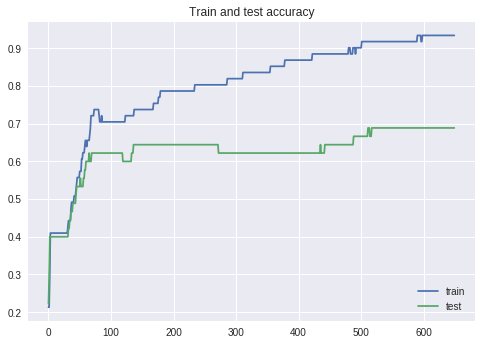

In [32]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0]) # Функція втрат
print('Test accuracy:', score[1]) # Загальна точність


# зображаємо на графіку точність для тестового та навчального сетів 
plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('Train and test accuracy')
plt.show()

Як бачимо, загальна точність виявилаь досить слабкою. Подивимось уважніше на точність для визначення кожного із захворювань (параметри "recall" та "precision"):

In [41]:
# Обчислюємо параметри "recall" та "precision"

classes=['Carcinoma',
'Fibro-adenoma',
'Mastopathy',
'Glandular',
'Connective',
'Adipose']

y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred, axis =1) # конвертуємо із векторної форми в цілі числа
y_temp_test = np.argmax(y_test,axis = 1) # конвертуємо із векторної форми в цілі числа

recall = metrics.recall_score(y_temp_test,y_pred,average=None)
precision = metrics.precision_score(y_temp_test,y_pred,average=None)

for i,j,k in zip(recall,precision,classes):
  
  print(k,': ')
  print('   recall:    ', round(i,2))
  print('   precision: ', round(j,2),'\n')

Carcinoma : 
   recall:     0.89
   precision:  0.8 

Fibro-adenoma : 
   recall:     0.67
   precision:  0.44 

Mastopathy : 
   recall:     0.38
   precision:  0.5 

Glandular : 
   recall:     0.43
   precision:  0.6 

Connective : 
   recall:     0.83
   precision:  0.83 

Adipose : 
   recall:     0.89
   precision:  0.89 



Точність для визначення фіброаденоми, мастопатії та мононуклеозу справді виявилась низькою, порівняно з іншими хворобами, тому доцільно звести ці три захворювання в одну групу.

In [0]:
for i in [1,2,3]: #переписуємо класи 1,2,3 (Fibro-adenoma, Mastopathy, Glandular) в нову групу
  y[y == i] = 1

y[y == 4] = 2
y[y == 5] = 3

In [0]:
# Оскільки вибірка мала, проводимо "train test split" для кожного класу хвороб окремо

x_test = []
y_test = []
x_train = []
y_train = []

for i in np.unique(y):
  
  temp_x_train, temp_x_test, temp_y_train, temp_y_test = train_test_split(x[y==i], y[y==i], test_size=0.4, random_state = 3)
  
  x_test += temp_x_test.tolist()
  y_test += temp_y_test.tolist()
  x_train += temp_x_train.tolist()
  y_train += temp_y_train.tolist()

x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = np.array(x_train)
y_train = np.array(y_train)

# Перевіряємо, які класи хвороб потрапили у вибірку і яка їх кількість
print('test: ',np.unique(y_test, return_counts = True))
print('train: ',np.unique(y_train, return_counts = True))

In [0]:
cl_n=['Carcinoma',
'Fibro-adenoma',
'Mastopathy',
'Glandular',
'Connective',
'Adipose']


In [0]:
# конвертуємо класи хвороб у векторну форму
num_category = 6

y_train = keras.utils.to_categorical(y_train, num_category)
y_test = keras.utils.to_categorical(y_test, num_category)

In [177]:
# будуємо модель

batch_size = y_train.shape[0] # використовуємо "batch_size" розміром з нашу вибірку

model = Sequential()
model.add(Dense(240, activation='relu') )
model.add(Dropout(0.7))
model.add(Dense(num_category, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(lr=0.005),
                metrics=['accuracy'])


num_epoch = 300


model_log = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=num_epoch,
                verbose=2,
                validation_data=(x_test, y_test), 
                        )



Train on 62 samples, validate on 44 samples
Epoch 1/300
 - 3s - loss: 1.7865 - acc: 0.1613 - val_loss: 1.6947 - val_acc: 0.5227
Epoch 2/300
 - 0s - loss: 1.7001 - acc: 0.3387 - val_loss: 1.6222 - val_acc: 0.5909
Epoch 3/300
 - 0s - loss: 1.6298 - acc: 0.5645 - val_loss: 1.5551 - val_acc: 0.6364
Epoch 4/300
 - 0s - loss: 1.5686 - acc: 0.5806 - val_loss: 1.4918 - val_acc: 0.6591
Epoch 5/300
 - 0s - loss: 1.5509 - acc: 0.6613 - val_loss: 1.4327 - val_acc: 0.6591
Epoch 6/300
 - 0s - loss: 1.4597 - acc: 0.6452 - val_loss: 1.3773 - val_acc: 0.6591
Epoch 7/300
 - 0s - loss: 1.3895 - acc: 0.6613 - val_loss: 1.3247 - val_acc: 0.6591
Epoch 8/300
 - 0s - loss: 1.3510 - acc: 0.6774 - val_loss: 1.2747 - val_acc: 0.6591
Epoch 9/300
 - 0s - loss: 1.3313 - acc: 0.6774 - val_loss: 1.2278 - val_acc: 0.6591
Epoch 10/300
 - 0s - loss: 1.2659 - acc: 0.6613 - val_loss: 1.1835 - val_acc: 0.6591
Epoch 11/300
 - 0s - loss: 1.2655 - acc: 0.6774 - val_loss: 1.1416 - val_acc: 0.6591
Epoch 12/300
 - 0s - loss: 1.1

Test loss: 0.28361100229350006
Test accuracy: 0.9318181872367859


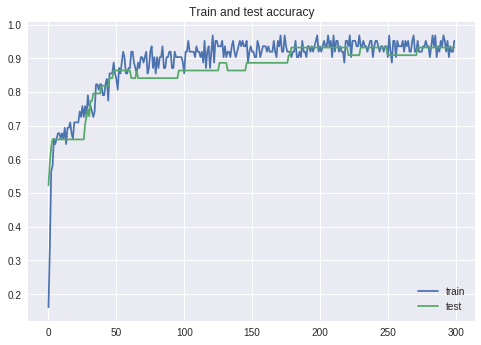

In [178]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0]) # Функція втрат
print('Test accuracy:', score[1]) # Загальна точність


# зображаємо на графіку точність для тестового та навчального сетів 
plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('Train and test accuracy')
plt.show()

In [181]:
# Обчислюємо параметри "recall" та "precision"

classes=['Carcinoma',
'Fibro-adenoma/ Mastopathy/ Glandular',
'Connective',
'Adipose']

y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred, axis =1) # конвертуємо із векторної форми в цілі числа
y_temp_test = np.argmax(y_test,axis = 1) # конвертуємо із векторної форми в цілі числа

recall = metrics.recall_score(y_temp_test,y_pred,average=None)
precision = metrics.precision_score(y_temp_test,y_pred,average=None)

for i,j,k in zip(recall,precision,classes):
  
  print(k,': ')
  print('   recall:    ', round(i,2))
  print('   precision: ', round(j,2),'\n')

Carcinoma : 
   recall:     1.0
   precision:  0.82 

Fibro-adenoma/ Mastopathy/ Glandular : 
   recall:     0.9
   precision:  1.0 

Connective : 
   recall:     1.0
   precision:  0.86 

Adipose : 
   recall:     0.89
   precision:  1.0 



Як бачимо, точність передбачень значно зросла. Отримана нейромережа є достатньою для визначення даних класів хвороб.